# Example Fourier Frequency DEM Analysis

This python notebook will demonstrate the 2D Discrete Fourier Transform (DFT) applied to two gridded Digital Elevation Models (DEMs). This analysis can help highlight characteristic length scales in the natural landscape and also high-frequency noise present in the DEMs. 

For background reading see:

* Perron, J. T., Kirchner, J. W., and Dietrich, W. E.: Spectral signatures of characteristic spatial scales and nonfractal structure in landscapes, Journal of Geophysical Research, 113, 2008. [https://doi.org/10.1029/2007JF000866](https://doi.org/10.1029/2007JF000866)


* Purinton, B., and Bookhagen, B.: Validation of digital elevation models (DEMs) and geomorphic metrics on the southern Central Andean Plateau, Earth Surface Dynamics, 2017. [https://doi.org/10.5194/esurf-5-211-2017](https://doi.org/10.5194/esurf-5-211-2017)

### DEMs

To demonstrate this analysis we will use two DEMs with resolutions of 30 m:

1. The SRTM DEM: https://www2.jpl.nasa.gov/srtm/
2. The ASTER DEM: https://asterweb.jpl.nasa.gov/gdem.asp

### Requirements

The code requires the packages:

* *numpy, matplotlib, scipy, gdal*


# The Code

We start by importing some useful packages

In [29]:
# import some python packages 
import numpy as np
from scipy import stats
from osgeo import gdal
from matplotlib import pyplot as plt
import warnings

# ignore some warnings
warnings.filterwarnings('ignore')

# set figure size
plt.rcParams['figure.figsize'] = [15, 10]

In [30]:
# load in some helper functions
def tif2nparray(geotif_file, clip=[]):
    """
    This function takes a geotiff and loads it as
    a numpy array and also provides the metadata.
    The clip variable can be used to specify a geographic
    region of interest from the full geotiff.
    """
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]

    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)

        if clip == []:
            array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        else:
            array = dataset.GetRasterBand(1).ReadAsArray(clip[0], clip[1], clip[2], clip[3]).astype(np.float)

        array[array==metadata['noDataValue']]=np.nan
        array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return np.flipud(array), metadata
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')
        
    dataset = None

def hillshade(array,azimuth,angle_altitude):
    """
    This function is used to generate a hillshade of the topography.
    """
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

Now we'll load each DEM separately

In [31]:
# load the ASTER DEM
aster_fn='example_data/aster30m_dem.tif'
aster_dem, aster_metadata = tif2nparray(aster_fn)
aster_hs = hillshade(aster_dem, 145, 45) # Create a hillshade for plotting

# the metadata provides us spatial information on the raster
print("The metadata dictionary is:\n{}".format(aster_metadata))

# we use this metadata to get the step size (pixel size)
aster_step = aster_metadata['pixelWidth']
print("\nPixel size is {} m".format(aster_step))

The metadata dictionary is:
{'array_rows': 1000, 'array_cols': 1000, 'bands': 1, 'driver': 'GeoTIFF', 'projection': '', 'geotransform': (149670.0, 30.0, 0.0, 7229730.0, 0.0, -30.0), 'pixelWidth': 30.0, 'pixelHeight': -30.0, 'ext_dict': {'xMin': 149670.0, 'xMax': 149703.33333333334, 'yMin': 7229696.666666667, 'yMax': 7229730.0}, 'extent': (149670.0, 149703.33333333334, 7229696.666666667, 7229730.0), 'noDataValue': None, 'scaleFactor': 1.0, 'bandstats': {'min': 2147.0, 'max': 5440.0, 'mean': 3360.18, 'stdev': 687.44}}

Pixel size is 30.0 m


In [32]:
# also load the SRTM DEM
srtm_fn='example_data/srtm30m_dem.tif'
srtm_dem, srtm_metadata = tif2nparray(srtm_fn)
srtm_hs = hillshade(srtm_dem, 145, 45) # Create a hillshade for plotting
srtm_step = srtm_metadata['pixelWidth']

Let's plot both DEMs side-by-side to get a quick sense of the data

Text(0.5, 1.0, 'SRTM 30m DEM')

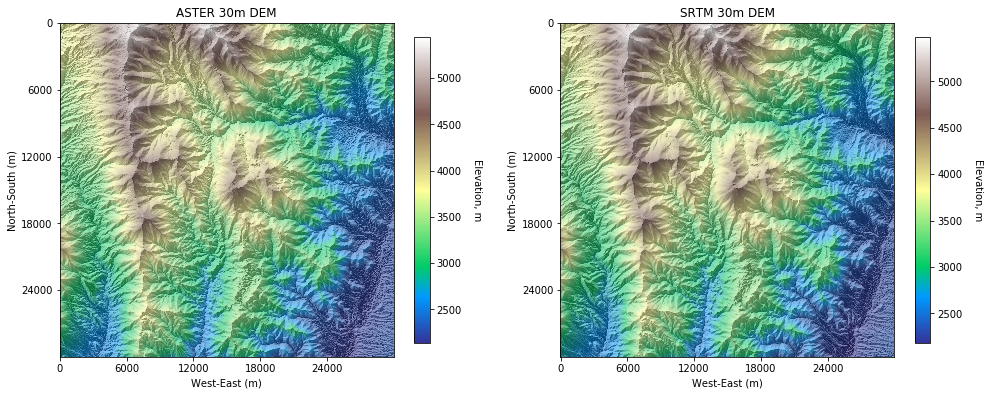

In [35]:
# instantiate a two column plot, using gridspec dictionary to make it fill up the space
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'left':0.1, 'right':0.95, 
                                                  'bottom':0.1, 'top':0.95})
# plot the DEM with hillshade
im = ax1.imshow(aster_dem, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax1, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax1.imshow(aster_hs, cmap='Greys', alpha=0.5)
# these next lines add some labels
ax1.set_xticklabels(["{:.0f}".format(x * aster_step) for x in ax1.get_xticks()])
ax1.set_yticklabels(["{:.0f}".format(y * aster_step) for y in ax1.get_yticks()])
ax1.set_xlabel("West-East (m)")
ax1.set_ylabel("North-South (m)")
ax1.set_title('ASTER 30m DEM')

im = ax2.imshow(srtm_dem, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax2, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax2.imshow(srtm_hs, cmap='Greys', alpha=0.5)
ax2.set_xticklabels(["{:.0f}".format(x * srtm_step) for x in ax2.get_xticks()])
ax2.set_yticklabels(["{:.0f}".format(y * srtm_step) for y in ax2.get_yticks()])
ax2.set_xlabel("West-East (m)")
ax2.set_ylabel("North-South (m)")
ax2.set_title('SRTM 30m DEM')

From this we see that the DEMs cover the same area and have similar elevation ranges. However, we may note that the ASTER DEM appears to have a slightly "grainy" texture at fine scales, whereas the SRTM appears smoother. Let's see if we can pull this out using a Fourier analysis!

**Note:** The following code is largely a translation of the MATLAB code provided in Taylor Perron's 2DSpecTools package, which is available here: http://web.mit.edu/perron/www/downloads.html

### First we set a few variables to select a DEM for analysis. We begin with the SRTM DEM

In [41]:
# set a few variables
fn = "SRTM 30m"
z = srtm_dem
hs = srtm_hs
step = srtm_step
skip = 1 # plot every n-th power value, for large grids (>2000*2000 pixels) use a skip of 2 or 3

### Pre-process the grid

In [42]:
# get the size of the raster and save a copy of the original grid
z_original = z.copy()
ny, nx = z.shape

# use linear algebra to fit a plane by least squares
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

In [43]:
# apply hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

In [44]:
# This next step is done to optimize the Cooley and Turkey (1965) 
# Discrete Fourier Transfom (DFT) method used by numpy, which operates 
# most efficiently when the length scales are powers of 2 and the grid
# is square
Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

In [45]:
# frequency increments
dfx = 1/(step*Lx)
dfy = 1/(step*Ly)

### Run the Fourier Transform

In [46]:
# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# get the DFT periodogram with units of m^2 for topography 
# include weights of hann to correct for windowing
p2d = abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# calculate radial frequencies
xc, yc = (Lx//2 + 1, Ly//2 + 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))
fx = (x - xc) * dfx
fy = (y - yc) * dfy
f2d = np.sqrt(fx**2 + fy**2)

# get the frequency and power as 1D vectors
p1d = p2d[:, 0:xc].ravel()  # only half the power (reflected across the center)
f1d = f2d[:, 0:xc].ravel()  # same for the frequency

### Fit a power-law to the 1D power to normalize the spectrum and highlight strong features

In [47]:
# bin the data using log bins
bins = 20
f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)
bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian, 
                                  bins=f_bins)
bin_center = edges[:-1] + np.diff(edges)/2

# sometimes NaN values remain in some bins, throw those bins out
bin_center = bin_center[np.isfinite(bin_med)]
bin_med = bin_med[np.isfinite(bin_med)]

# apply a power-law fit to the bins
A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
pl_fit = (10**fit[1]) * (bin_center**fit[0])

In [48]:
# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))

### Now plot the result for the SRTM DEM

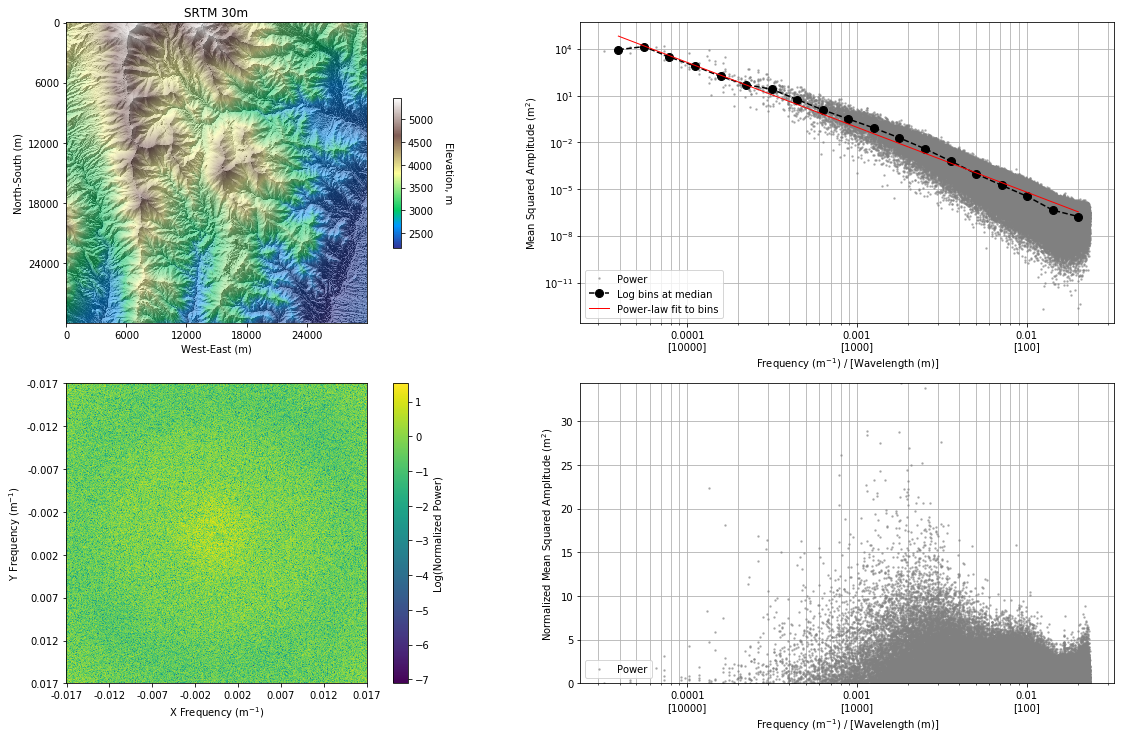

In [50]:
# make a figure
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8),
                               gridspec_kw={'left':0.1, 'right':0.95, 
                                            'bottom':0.1, 'top':0.95})
ax1, ax2, ax3, ax4 = axes[0, 1], axes[1, 1], axes[0, 0], axes[1, 0]

# first plot the original 1D power specturm
ax1.loglog(f1d[::skip], p1d[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax1.loglog(bin_center, bin_med, 'ko--', markersize=8, alpha=1, 
          label="Log bins at median")
ax1.loglog(bin_center, pl_fit, 'r-', lw=1, label="Power-law fit to bins")
ax1.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax1.get_xticks()])
ax1.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax1.set_ylabel('Mean Squared Amplitude (m$^2$)')
ax1.grid(True, which="both")
ax1.legend(loc='lower left', fontsize=10)

# then plot the normalized 1D power specturm
ax2.semilogx(f1d[::skip], p1d_norm[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax2.set_ylim(0, p1d_norm.max())
ax2.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax2.get_xticks()])
ax2.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax2.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax2.grid(True, which="both")
ax2.legend(loc='lower left', fontsize=10)

# now plot the original DEM
im = ax3.imshow(z_original, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax3, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax3.imshow(hs, cmap='Greys', alpha=0.5)
# these next lines add some labels
ax3.set_xticklabels(["{:.0f}".format(x * step) for x in ax3.get_xticks()])
ax3.set_yticklabels(["{:.0f}".format(y * step) for y in ax3.get_yticks()])
ax3.set_xlabel("West-East (m)")
ax3.set_ylabel("North-South (m)")
ax3.set_title(fn)

# also plot the normalized 2D power spectrum
im = ax4.imshow(np.log10(p2d_norm))
fig.colorbar(im, ax=ax4, label="Log(Normalized Power)")
ax4.set_xlabel("X Frequency (m$^{-1}$)")
ax4.set_ylabel("Y Frequency (m$^{-1}$)")
nfy, nfx = f2d.shape
nyq = f2d[nfy//2 + 1, 0]
n_labels = 8
ax4.set_xticks(np.linspace(1, nfx, n_labels))
ax4.set_yticks(np.linspace(1, nfy, n_labels))
ticks = ["{:.3f}".format(a) for a in np.linspace(-nyq, nyq, n_labels)]
ax4.set_xticklabels(ticks)
ax4.set_yticklabels(ticks)

plt.show()

# What do we see here?

It looks like the SRTM power spectrum is fairly smooth with some higher values around ~800-1000 m. This length scale corresponds to the approximate spacing of the small scale ridges and valleys throughout the image. This peak in power is, however, rather diffuse over a large wavelength range since the DEM area selected contains many features of smaller and larger size. We do not see any really noticeable high frequency noise at lower wavelength (< 100 m), which might be cause for concern...

## What about for ASTER?

Let's have a look at our other dataset below.

### First let's change the variables

In [51]:
# set a few variables
fn = "ASTER 30m"
z = aster_dem
hs = aster_hs
step = aster_step
skip = 1 # plot every n-th power value, for large grids (>2000*2000 pixels) use a skip of 2 or 3

### For this run, we'll just do it all in one block to get a quick figure for comparison

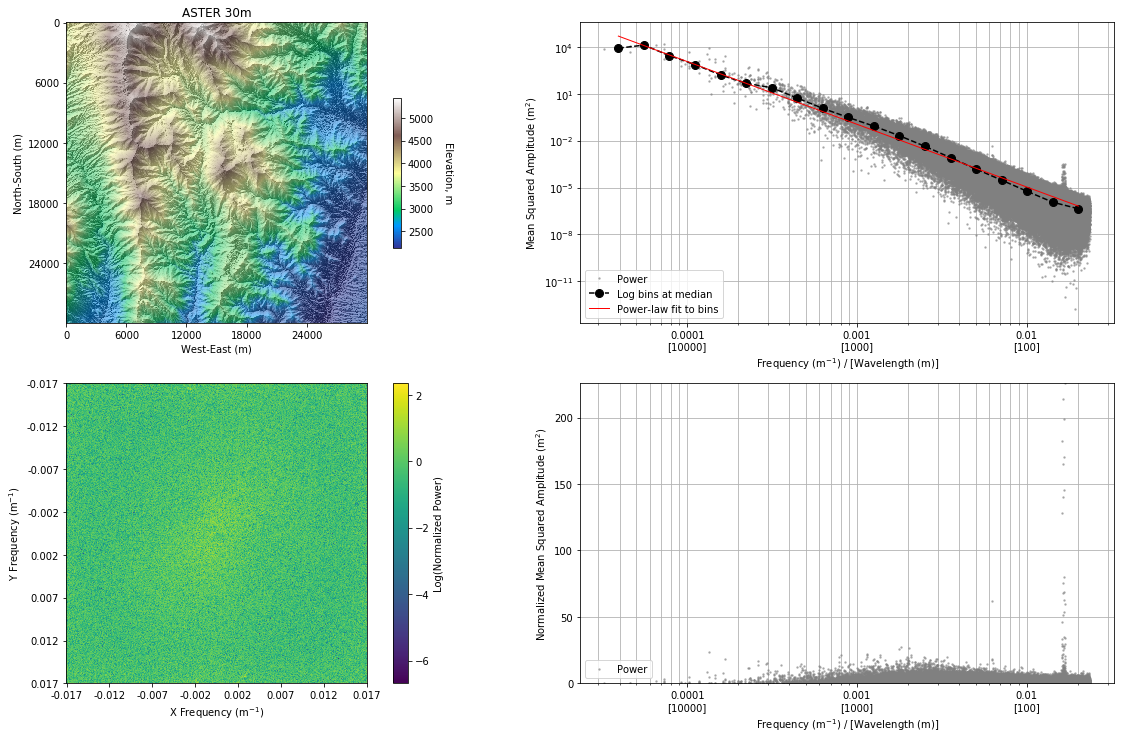

In [52]:
# get the size of the raster and save a copy of the original grid
z_original = z.copy()
ny, nx = z.shape

# use linear algebra to fit a plane by least squares
x, y = np.meshgrid(range(nx), range(ny))
A = np.vstack([x.ravel(), y.ravel(), np.ones(len(x.ravel()))]).T
fit = np.linalg.lstsq(A, z.ravel(), rcond=None)[0]
z = z - (fit[0]*x + fit[1]*y + fit[2])

# apply hanning windowing to reduce spectral leakage on edges
hann_y = np.hanning(ny)
hann_x = np.hanning(nx)
hann_2d = np.sqrt(np.outer(hann_y, hann_x))
hann_weight = np.sum(hann_2d ** 2)
z = z * hann_2d

# This next step is done to optimize the Cooley and Turkey (1965) 
# Discrete Fourier Transfom (DFT) method used by numpy, which operates 
# most efficiently when the length scales are powers of 2 and the grid
# is square
Lx = int(2**(np.ceil(np.log(np.max((nx, ny)))/np.log(2))))
Ly = Lx

# frequency increments
dfx = 1/(step*Lx)
dfy = 1/(step*Ly)

# run the fft
fft = np.fft.fftn(z, (Ly, Lx))

# shift zero frequency to center
fft_shift = np.fft.fftshift(fft)

# get the DFT periodogram with units of m^2 for topography 
# include weights of hann to correct for windowing
p2d = abs(fft_shift)**2 / (Lx * Ly * hann_weight)

# calculate radial frequencies
xc, yc = (Lx//2 + 1, Ly//2 + 1) # center coordinate
x, y = np.meshgrid(range(Lx), range(Ly))
fx = (x - xc) * dfx
fy = (y - yc) * dfy
f2d = np.sqrt(fx**2 + fy**2)

# get the frequency and power as 1D vectors
p1d = p2d[:, 0:xc].ravel()  # only half the power (reflected across the center)
f1d = f2d[:, 0:xc].ravel()  # same for the frequency

# bin the data using log bins
bins = 20
f_bins = np.logspace(np.log10(f1d.min()), np.log10(f1d.max()), num=bins)
bin_med, edges, _ = stats.binned_statistic(f1d, p1d, statistic=np.nanmedian, 
                                  bins=f_bins)
bin_center = edges[:-1] + np.diff(edges)/2

# sometimes NaN values remain in some bins, throw those bins out
bin_center = bin_center[np.isfinite(bin_med)]
bin_med = bin_med[np.isfinite(bin_med)]

# apply a power-law fit to the bins
A = np.vstack([np.log10(bin_center), np.ones(len(bin_center))]).T
fit = np.linalg.lstsq(A, np.log10(bin_med), rcond=None)[0]
pl_fit = (10**fit[1]) * (bin_center**fit[0])

# use the power-law fit to normalize the 1D spectrum
p1d_norm = p1d / ((10**fit[1]) * (f1d**fit[0]))

# use the power-law fit to normalize the 2D spectrum
p2d_norm = p2d / ((10**fit[1]) * (f2d**fit[0]))

# make a figure
fig, axes = plt.subplots(2, 2, figsize=(19.2, 10.8),
                               gridspec_kw={'left':0.1, 'right':0.95, 
                                            'bottom':0.1, 'top':0.95})
ax1, ax2, ax3, ax4 = axes[0, 1], axes[1, 1], axes[0, 0], axes[1, 0]

# first plot the original 1D power specturm
ax1.loglog(f1d[::skip], p1d[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax1.loglog(bin_center, bin_med, 'ko--', markersize=8, alpha=1, 
          label="Log bins at median")
ax1.loglog(bin_center, pl_fit, 'r-', lw=1, label="Power-law fit to bins")
ax1.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax1.get_xticks()])
ax1.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax1.set_ylabel('Mean Squared Amplitude (m$^2$)')
ax1.grid(True, which="both")
ax1.legend(loc='lower left', fontsize=10)

# then plot the normalized 1D power specturm
ax2.semilogx(f1d[::skip], p1d_norm[::skip], '.', c='gray', alpha=0.5, markersize=3, Label="Power",
          rasterized=True)
ax2.set_ylim(0, p1d_norm.max())
ax2.set_xticklabels(["{:}\n[{:.0f}]".format(a, 1/a) for a in ax2.get_xticks()])
ax2.set_xlabel('Frequency (m$^{-1}$) / [Wavelength (m)]')
ax2.set_ylabel('Normalized Mean Squared Amplitude (m$^2$)')
ax2.grid(True, which="both")
ax2.legend(loc='lower left', fontsize=10)

# now plot the original DEM
im = ax3.imshow(z_original, cmap='terrain') 
cbar = plt.colorbar(im, ax=ax3, shrink=0.5)
cbar.set_label('Elevation, m', rotation=270, labelpad=20)
ax3.imshow(hs, cmap='Greys', alpha=0.5)
# these next lines add some labels
ax3.set_xticklabels(["{:.0f}".format(x * step) for x in ax3.get_xticks()])
ax3.set_yticklabels(["{:.0f}".format(y * step) for y in ax3.get_yticks()])
ax3.set_xlabel("West-East (m)")
ax3.set_ylabel("North-South (m)")
ax3.set_title(fn)

# also plot the normalized 2D power spectrum
im = ax4.imshow(np.log10(p2d_norm))
fig.colorbar(im, ax=ax4, label="Log(Normalized Power)")
ax4.set_xlabel("X Frequency (m$^{-1}$)")
ax4.set_ylabel("Y Frequency (m$^{-1}$)")
nfy, nfx = f2d.shape
nyq = f2d[nfy//2 + 1, 0]
n_labels = 8
ax4.set_xticks(np.linspace(1, nfx, n_labels))
ax4.set_yticks(np.linspace(1, nfy, n_labels))
ticks = ["{:.3f}".format(a) for a in np.linspace(-nyq, nyq, n_labels)]
ax4.set_xticklabels(ticks)
ax4.set_yticklabels(ticks)

plt.show()

# Voilà! High-frequency noise!

We see here the diffuse ~800-1000 m landscape frequency is now obscured by a huge power spike around ~90 m (or three ASTER pixels). This is the high-frequency noise so prevelant in optically generated DEMs, which you can read more about here:

https://www.earth-surf-dynam.net/5/211/2017/